In [166]:
import glob
import joblib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [170]:
def load_results(path):
    """
    Given a glob path to all the data.jl, load them
    """
    files = glob.glob(path)
    data = {}
    for i in files:
        name = i.split('/')[-2]
        x = joblib.load(i)
        x = x.groupby(['szbin', 'state']).size().unstack()
        x['recall'] = x['tpbase'] / (x['tpbase'] + x['fn'])
        x['precision'] = x['tp'] / (x['tp'] + x['fp'])
        x['f1'] = 2 * (x['recall'] * x['precision']) / (x['recall'] + x['precision'])
        idx = name.rindex('_')
        x['sample'] = name[idx+1:]
        x['prog'] = name[:idx]
        data[name] = x.fillna(0)
    return data

In [179]:
plain = load_results("../benchmarking/results/cmrg_svsmall/*/data.jl")
plain['truvari_d_hprc']

state,tpbase,fn,tp,fp,recall,precision,f1,sample,prog
szbin,,,,,,,,,
SNP,0,0,0,0,0.000000,0.000000,0.000000,hprc,truvari_d
"[1,5)",0,0,0,0,0.000000,0.000000,0.000000,hprc,truvari_d
"[5,10)",0,0,0,0,0.000000,0.000000,0.000000,hprc,truvari_d
"[10,15)",0,0,0,0,0.000000,0.000000,0.000000,hprc,truvari_d
"[15,20)",0,0,0,0,0.000000,0.000000,0.000000,hprc,truvari_d
"[20,30)",0,0,0,0,0.000000,0.000000,0.000000,hprc,truvari_d
"[30,40)",0,0,0,0,0.000000,0.000000,0.000000,hprc,truvari_d
"[40,50)",0,0,1,0,0.000000,1.000000,0.000000,hprc,truvari_d
"[50,100)",62,2,61,8,0.968750,0.884058,0.924468,hprc,truvari_d


In [183]:
def make_szplot(data, keys, y_val='f1', title="CMRG vs Adotto"):
    """
    keys is list of tuples, (key, label)
    """
    plt.figure(dpi=180)
    for k, l in keys:
        j = data[k]
        p = sb.lineplot(data=j, x=j.index, y=y_val, label=l)
    title += " " + y_val
    p.set(xlabel="SZBIN", title=title)
    hide = plt.xticks(rotation=45, ha='right')
    plt.grid(axis='x')

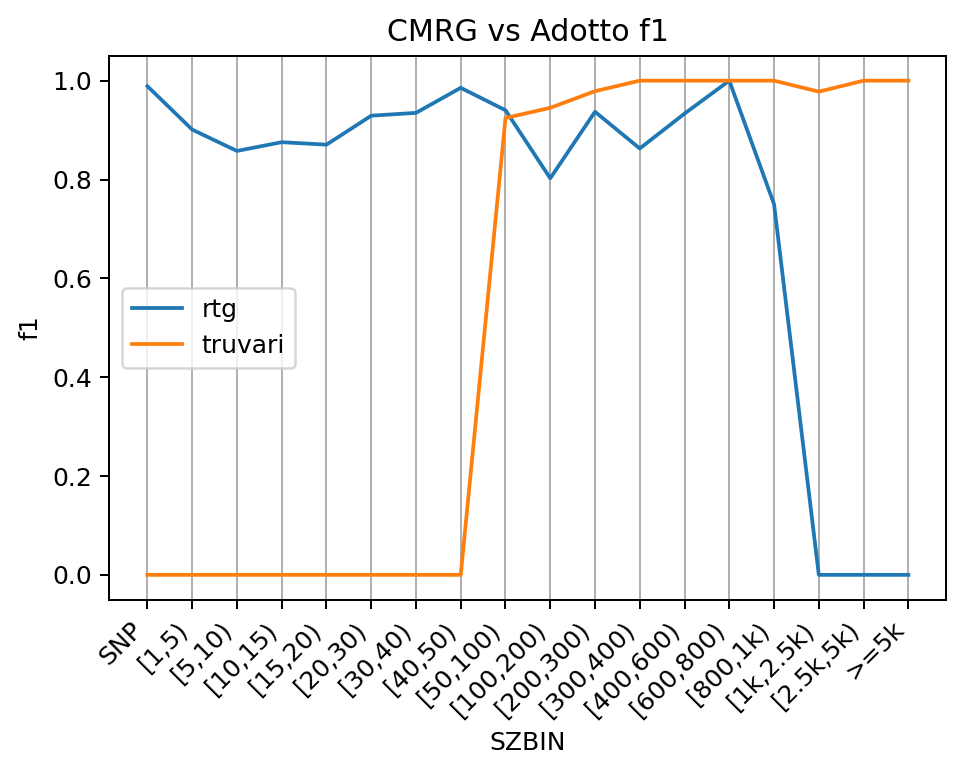

In [184]:
make_szplot(plain, [('rtg_hprc', 'rtg'), ('truvari_d_hprc', 'truvari')])

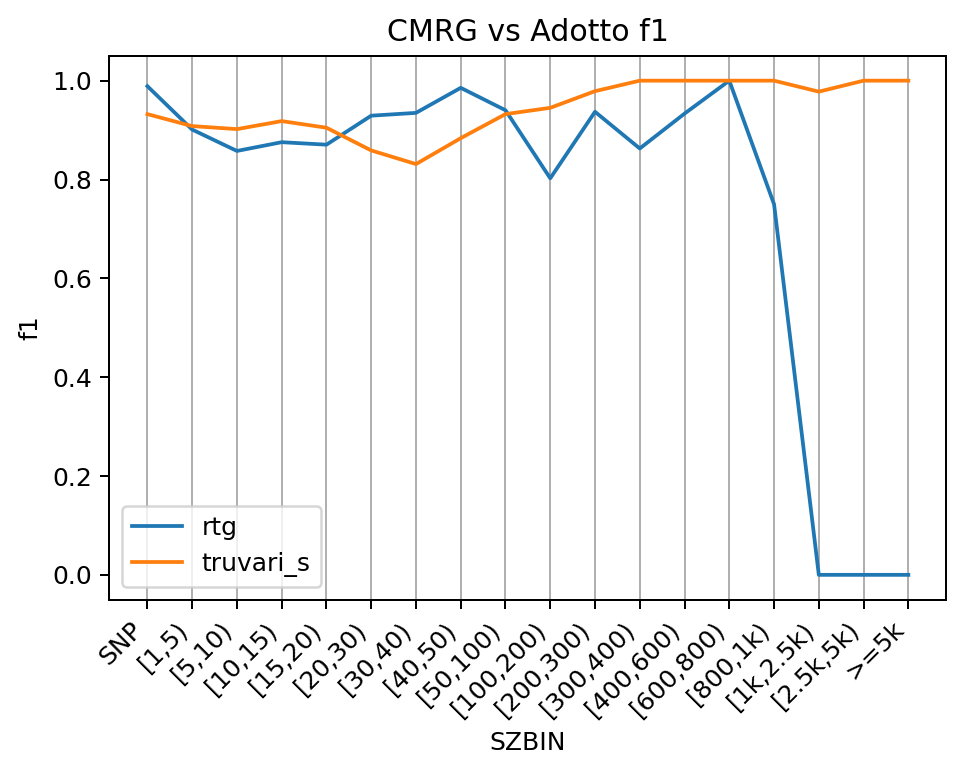

In [207]:
make_szplot(plain, [('rtg_hprc', 'rtg'), 
                   ('truvari_s_hprc', 'truvari_s')])

In [191]:
real_base_vars = joblib.load("../benchmarking/results/cmrg_region_truth.jl")
real_base_counts = real_base_vars['szbin'].value_counts()
real_base_counts

SNP          18640
[1,5)         4287
[5,10)         545
[10,15)        214
[20,30)        156
[15,20)        146
[50,100)        64
[30,40)         56
[100,200)       44
[40,50)         35
[300,400)       26
[200,300)       24
[1k,2.5k)       22
[400,600)       15
[600,800)        7
>=5k             6
[2.5k,5k)        5
[800,1k)         4
Name: szbin, dtype: int64

In [193]:
rtg_base_cnts = plain['rtg_hprc']['tpbase'] + plain['rtg_hprc']['fn']
rtg_base_cnts

szbin
SNP          18525
[1,5)         4267
[5,10)         538
[10,15)        212
[15,20)        145
[20,30)        154
[30,40)         56
[40,50)         35
[50,100)        64
[100,200)       44
[200,300)       24
[300,400)       26
[400,600)       15
[600,800)        7
[800,1k)         4
[1k,2.5k)        0
[2.5k,5k)        0
>=5k             0
dtype: int64

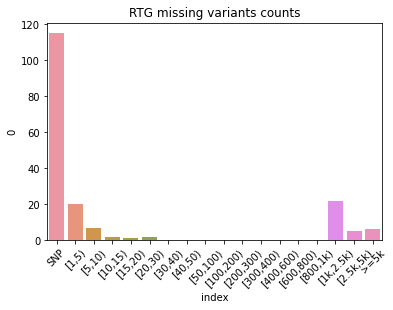

In [205]:
p = sb.barplot(data=(real_base_counts - rtg_base_cnts).to_frame().reset_index(), x="index", y=0)
plt.xticks(rotation=45)
hide = p.set(title="RTG missing variants counts")

In [219]:
phab_region = joblib.load("../benchmarking/results/phab.raw.jl")

x = phab_region.groupby(['szbin', 'state']).size().unstack()
x['recall'] = x['tp'] / (x['tp'] + x['fn'])
x['precision'] = x['tp'] / (x['tp'] + x['fp'])
x['f1'] = 2 * (x['recall'] * x['precision']) / (x['recall'] + x['precision'])
x['sample'] = 'hprc'
x['prog'] = 'phab:gt'
x
plain['phab:gt_hprc'] = x

In [213]:
def size_regime_performance(df, sizes):
    cnts = df.loc[sizes][['tp', 'fp', 'fn', 'tpbase']].sum()
    precision = cnts['tp'] / (cnts['tp'] + cnts['fp'])
    recall = cnts['tpbase']/ (cnts['tpbase'] + cnts['fn'])
    f1 = 2 * (recall * precision) / (recall + precision)
    return precision, recall, f1

small_sz = plain['rtg_hprc'].index[2:8]

rows = []
for key in plain.keys():
    if key.startswith("truvari_d"): continue
    name = key.split('_')[0]
    comp = key.split('_')[-1]
    m_row = list(size_regime_performance(plain[key], small_sz))
    m_row.insert(0, comp)
    m_row.insert(0, name)
    rows.append(m_row)

m_small_perf = pd.DataFrame(rows, columns=["prog", "comp", "precision", "recall", "f1"])
m_small_perf

,prog,comp,precision,recall,f1
0,truvari,eichler,0.884268,0.848827,0.866185
1,rtg,eichler,0.824463,0.833333,0.828874
2,truvari,hprc,0.934597,0.860122,0.895814
3,rtg,hprc,0.883302,0.876316,0.879795
4,rtg,li,0.763181,0.807895,0.784902
5,truvari,li,0.842197,0.839270,0.840731


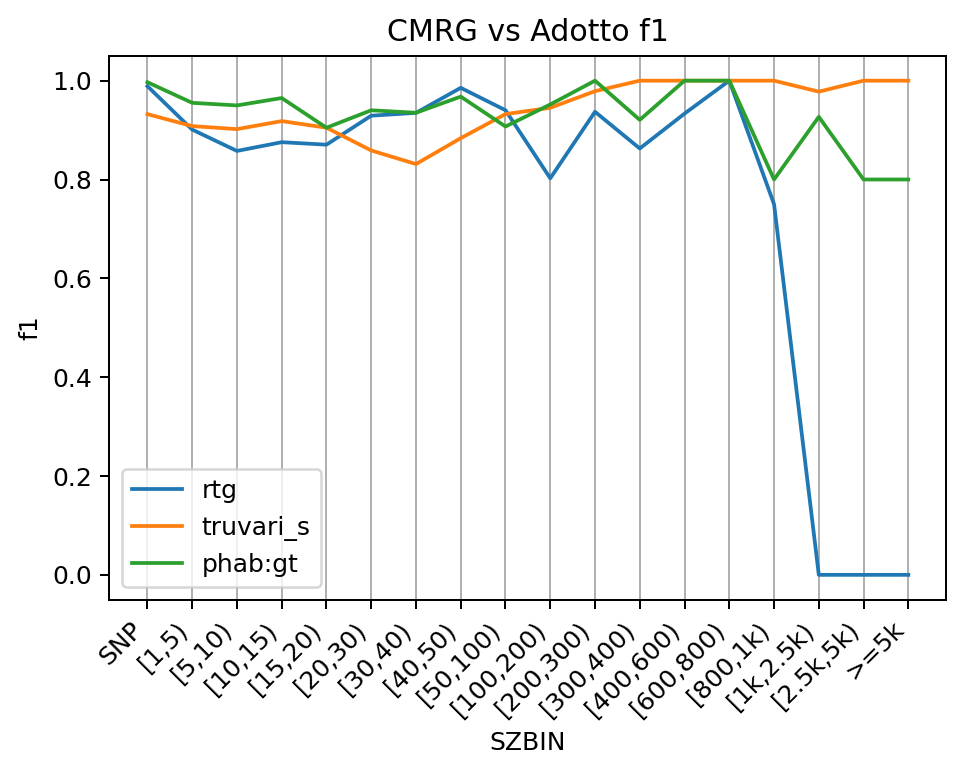

In [220]:
make_szplot(plain, [('rtg_hprc', 'rtg'), 
                   ('truvari_s_hprc', 'truvari_s'),
                   ('phab:gt_hprc', 'phab:gt')])

In [224]:
x = plain["truvari_s_hprc"]
tp = x['tp'].sum()
tpbase = x['tpbase'].sum()
fp = x['fp'].sum()
fn = x['fn'].sum()

recall = tpbase / (tpbase + fn)
precision = tp / (tp + fp)
f1 = 2 * (recall * precision) / (recall + precision)
summary = pd.Series([tpbase, tp, fp, fn, recall, precision, f1], index=['tpbase', 'tp', 'fp', 'fn', 'recall', 'precision', 'f1'])
summary

tpbase       23472.000000
tp           23472.000000
fp            2878.000000
fn             820.000000
recall           0.966244
precision        0.890778
f1               0.926978
dtype: float64

In [228]:
phab = load_results("../benchmarking/results/cmrg_region_phab/*/data.jl")
phab['phab:gt_hprc'] = plain['phab:gt_hprc']

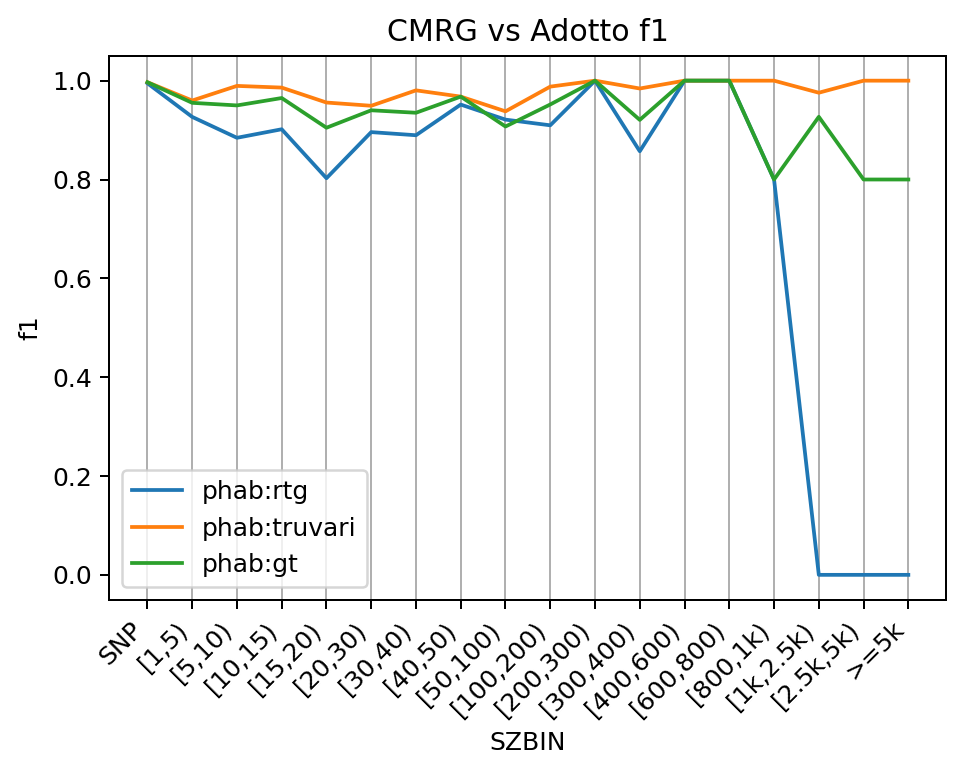

In [229]:
make_szplot(phab, [('rtg_hprc', 'phab:rtg'), 
                   ('truvari_hprc', 'phab:truvari'),
                   ('phab:gt_hprc', 'phab:gt')])

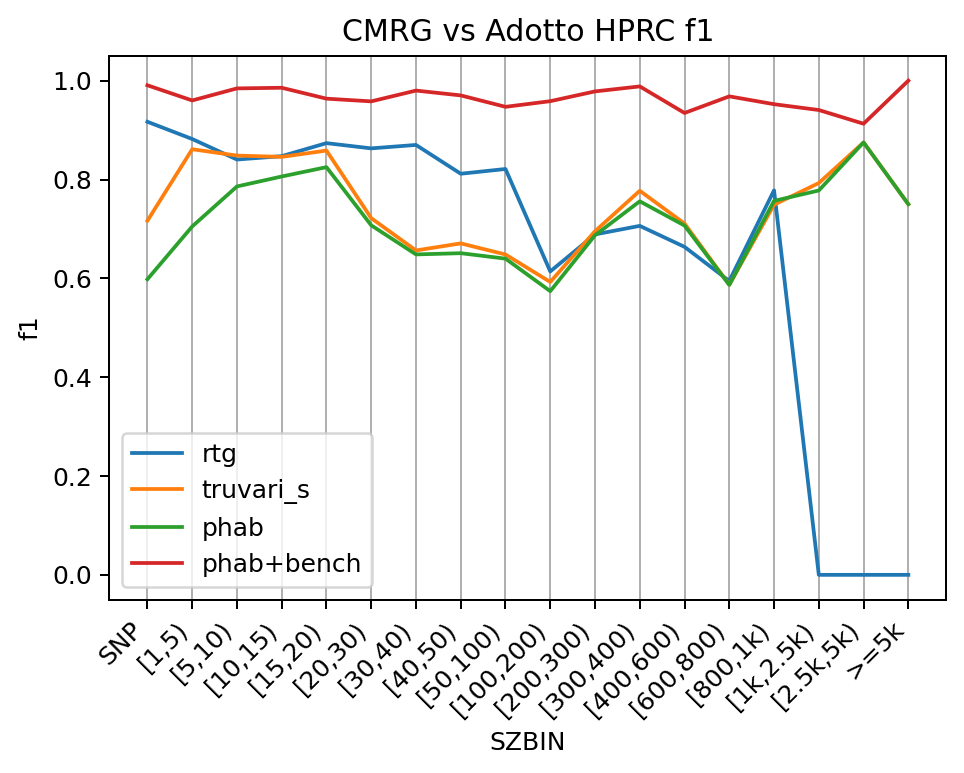

In [156]:
plt.figure(dpi=180)
y_val = 'f1'

j = data['rtg_hprc']
sb.lineplot(data=j, x=j.index, y=y_val, label="rtg")
j = data['truvari_s_hprc']
p = sb.lineplot(data=j, x=j.index, y=y_val, label="truvari_s")
j = data['phab']
p = sb.lineplot(data=j, x=j.index, y=y_val, label="phab")
j = data['truvari_phabbenchs_hprc']
sb.lineplot(data=j, x=j.index, y=y_val, label="phab+bench")
p.set(xlabel="SZBIN", title=f"CMRG vs Adotto HPRC {y_val}")
hide = plt.xticks(rotation=45, ha='right')
plt.grid(axis='x')

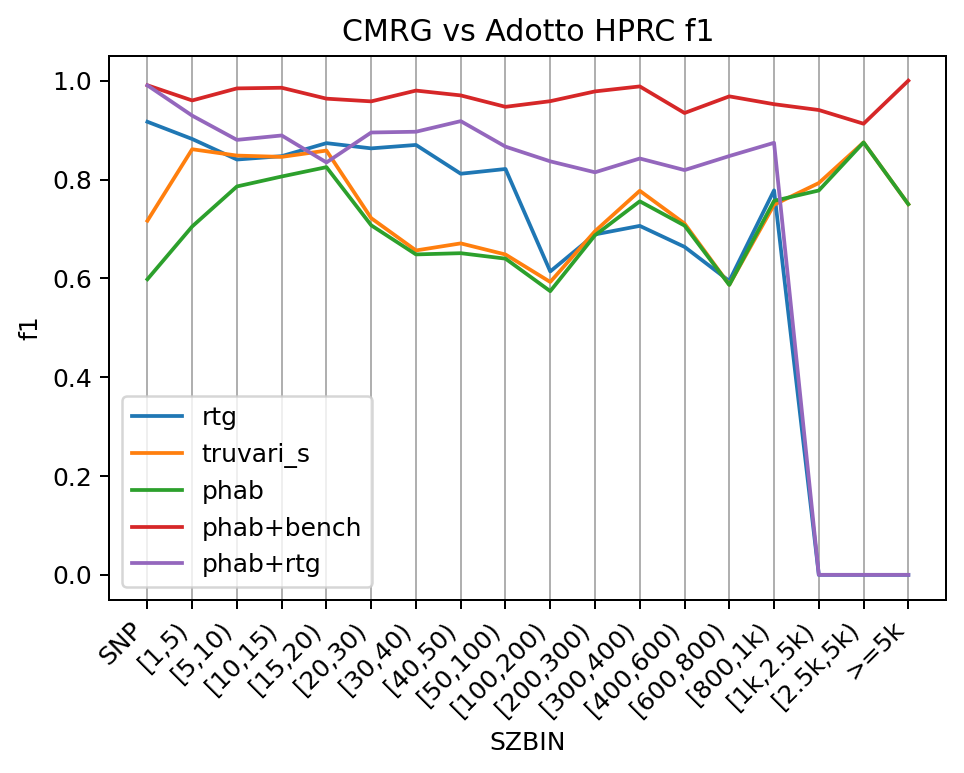

In [165]:
plt.figure(dpi=180)
y_val = 'f1'

j = data['rtg_hprc']
sb.lineplot(data=j, x=j.index, y=y_val, label="rtg")
j = data['truvari_s_hprc']
p = sb.lineplot(data=j, x=j.index, y=y_val, label="truvari_s")
j = data['phab']
p = sb.lineplot(data=j, x=j.index, y=y_val, label="phab")
j = data['truvari_phabbenchs_hprc']
sb.lineplot(data=j, x=j.index, y=y_val, label="phab+bench")
j = data['rtg_phab_hprc']
sb.lineplot(data=j, x=j.index, y=y_val, label="phab+rtg")
p.set(xlabel="SZBIN", title=f"CMRG vs Adotto HPRC {y_val}")
hide = plt.xticks(rotation=45, ha='right')
plt.grid(axis='x')

In [127]:
data.keys()

dict_keys(['truvari_d_eichler', 'truvari_phabbenchs_hprc', 'truvari_d_hprc', 'truvari_s_eichler', 'truvari_phabbench_hprc', 'rtg_eichler', 'truvari_d_li', 'truvari_s_hprc', 'rtg_hprc', 'rtg_li', 'truvari_s_li'])

In [111]:
reg = joblib.load("../benchmarking/results/bench_results.jl.summary.jl")
reg.sort_values('f1', inplace=True)

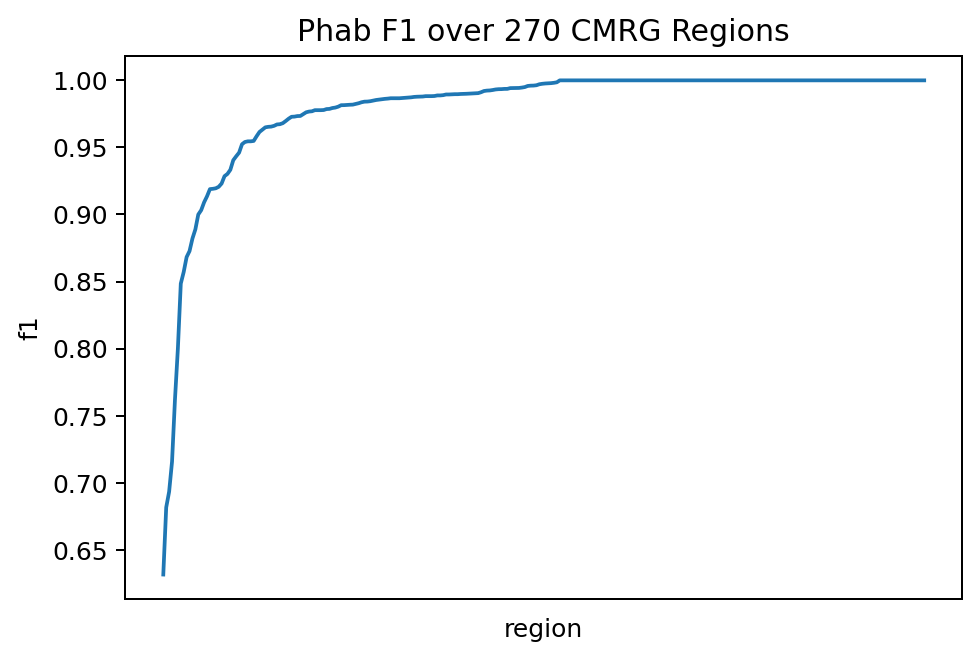

In [112]:
plt.figure(dpi=180)
p = sb.lineplot(data=reg, x="region", y="f1")
plt.xticks([])
hide = p.set(title=f"Phab F1 over {len(reg)} CMRG Regions")

In [113]:
len(reg), len(reg[reg['f1'].between(0.001, 0.95)]), len(reg[reg['f1'].isna()])

(270, 27, 8)

In [114]:
reg.to_csv("CMRG_v_Adotto_w_phab.txt", index=False, sep='\t')

In [122]:
reg[~reg['f1'].isna() & (reg['f1'] < 0.98)].tail()

,region,tp,fp,fn,precision,recall,f1
241,chr6:168441151-168673445,1039,28,19,0.973758,0.982042,0.977882
253,chr16:1351931-1414751,160,2,5,0.987654,0.969697,0.978593
254,chr16:2537979-2603188,23,0,1,1.000000,0.958333,0.978723
186,chr7:74289407-74405935,285,4,8,0.986159,0.972696,0.979381
68,chr1:23870515-23913362,338,7,7,0.979710,0.979710,0.979710


In [120]:
reg[reg['region'] == "chr9:110668779-110806558"]

,region,tp,fp,fn,precision,recall,f1
154,chr9:110668779-110806558,331,0,0,1.0,1.0,1.0
